# Convolutional Neural Network

### Libraries

In [1]:
# import libraries

import os
import cv2
import torch

import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.models import inception_v3, resnet50

from xml.etree import ElementTree as ET
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms
from torch import nn
from tqdm import tqdm
from sklearn.metrics import accuracy_score

### Data preparation

In [2]:
# major variables

photos_dir = './photos'
renders_dir = './renders'

In [3]:
def parse_xml(xml_file):
    '''
    Read the xml file and return the bounding box coordinates
    '''
    tree = ET.parse(xml_file)
    root = tree.getroot()
    bounding_boxes = []
    for obj in root.findall('object'):
        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)
        bounding_boxes.append([xmin, ymin, xmax, ymax])
    return bounding_boxes

In [4]:
def load_data(data_dir):
    '''
    Returns a list of images and labels for each image
    '''
    image_paths = []
    num_legos = []
    for subdir, _, files in os.walk(data_dir):
        for file in files:
            if file.endswith('.jpg'):
                n = int(subdir.split(os.sep)[-1])
                image_paths.append(os.path.join(subdir, file))
                num_legos.append(n)
    combined = list(zip(image_paths, num_legos))
    combined.sort()
    image_paths, num_legos = zip(*combined)
    image_paths = np.asarray(image_paths)
    num_legos = torch.Tensor(num_legos).to(torch.int64)
    return image_paths, num_legos

In [5]:

image_paths, num_legos = load_data(photos_dir)


In [6]:
# load data


# create 10 variations of the image and save them in the same directory
# this is done to increase the size of the dataset

transformations = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor()
])


def augment_data(folder_path):
    '''
    Augment the data
    '''
    image_paths = []

    for subdir, _, files in os.walk(folder_path):
        for file in files:
            if file.endswith('.jpg'):
                image_paths.append(os.path.join(subdir, file))
    print(image_paths)
    for image_path in image_paths:
        image = cv2.imread(image_path)
        for i in range(5):
            augmented = transformations(image)
            augmented = augmented.permute(1, 2, 0)  # change the channel order to HWC
            augmented = (augmented.numpy() * 255).astype('uint8')  # denormalize and convert to numpy array
            cv2.imwrite(folder_path+ f'_aug_{i}.jpg', augmented)

for x in range(6, 33):
    augment_data(f'{photos_dir}\\{x}\\')


['./photos\\6\\0_5WG9_original_1608912805106.jpg', './photos\\6\\IMG_20201127_002455.jpg', './photos\\6\\IMG_20201127_233648.jpg', './photos\\6\\IMG_20201127_234012.jpg', './photos\\6\\IMG_20201127_234528.jpg', './photos\\6\\IMG_20201203_091752.jpg']
['./photos\\7\\IMG_20201127_001602.jpg', './photos\\7\\IMG_20201127_003118.jpg', './photos\\7\\IMG_20201127_233710.jpg', './photos\\7\\IMG_20201127_233800.jpg', './photos\\7\\IMG_20201127_233804.jpg', './photos\\7\\IMG_20201127_233831.jpg', './photos\\7\\IMG_20201127_234018.jpg', './photos\\7\\IMG_20201127_234257.jpg']
['./photos\\8\\0_dBT8_original_1608912812791.jpg', './photos\\8\\IMG_20201127_001711.jpg', './photos\\8\\IMG_20201127_002319.jpg', './photos\\8\\IMG_20201127_002953.jpg', './photos\\8\\IMG_20201127_002957.jpg', './photos\\8\\IMG_20201127_003003.jpg', './photos\\8\\IMG_20201127_233659.jpg', './photos\\8\\IMG_20201127_233822.jpg', './photos\\8\\IMG_20201127_234054.jpg', './photos\\8\\IMG_20201127_234607.jpg']
['./photos\\9\\IM

In [27]:
# work with defined train test split
train_test_split = np.genfromtxt('./train_test_split.csv', delimiter=',', dtype=None, encoding=None)
train_test_ids = {
    'train': [],
    'test': []
}
for index, row in enumerate(train_test_split):
    if row[1] == '1':
      train_test_ids['test'].append(index - 1)
    elif row[1] == '0':
      train_test_ids['train'].append(index - 1)

print('Train:', len(train_test_ids['train']), 'Test:', len(train_test_ids['test']))

Train: 358 Test: 49


In [28]:
# validation set

indices = train_test_ids['test']
#np.random.shuffle(indices, )
print(indices)
test_size = 0.4 * len(indices)
split = int(np.floor(test_size))
train_test_ids['valid'], train_test_ids['test'] = indices[split:], indices[:split]

len(train_test_ids['train']), len(train_test_ids['valid']), len(train_test_ids['test'])

[3, 6, 16, 31, 32, 40, 44, 46, 66, 85, 98, 102, 106, 116, 122, 126, 130, 133, 134, 147, 148, 168, 192, 195, 202, 214, 224, 235, 236, 240, 241, 242, 244, 245, 304, 306, 307, 322, 324, 329, 335, 336, 338, 349, 358, 372, 379, 388, 396]


(358, 30, 19)

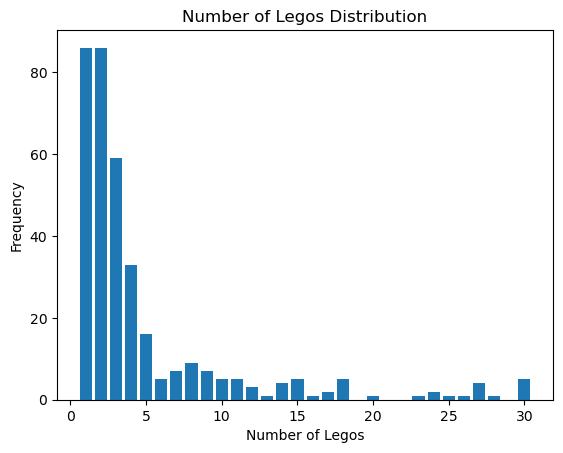

In [29]:
# class distribution in training data

num_legos_train = num_legos[train_test_ids['train']]
plt.hist(num_legos_train, bins=range(1, max(num_legos_train)), align='left', rwidth=0.8)
plt.xlabel('Number of Legos')
plt.ylabel('Frequency')
plt.title('Number of Legos Distribution')
plt.show()

In [10]:
# undersampling of larger class in training data
# indices = []
# for i in train_test_ids['train']:
#     if num_legos[i] == 1:
#         indices.append(i)
# np.random.shuffle(indices, )
# leftovers_size = 0.9 * len(indices)
# split = int(np.floor(leftovers_size))
# _, leftovers = indices[split:], indices[:split]
# for i in leftovers:
#     train_test_ids['train'].remove(i)

# num_legos_train = num_legos[train_test_ids['train']]
# plt.hist(num_legos_train, bins=range(1, max(num_legos_train)), align='left', rwidth=0.8)
# plt.xlabel('Number of Legos')
# plt.ylabel('Frequency')
# plt.title('Number of Legos Distribution')
# plt.show()

In [11]:
class LegosDataset(Dataset):
    '''
    Dataset class for the legos dataset
    '''
    def __init__(self, images_filenames, num_legos, transform=None):
        self.images_filenames = images_filenames
        self.transform = transform
        self.labels = num_legos

    def __len__(self):
        return len(self.images_filenames)

    def __getitem__(self, idx):
        image_filename = self.images_filenames[idx]
        label = self.labels[idx]
        image = cv2.imread(image_filename)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [12]:
# train, valid and test datasets

batch_size = 32
num_workers = 0

transform = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.Resize((299, 299)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)


train_dataset = LegosDataset(image_paths[train_test_ids['train']], num_legos[train_test_ids['train']], transform=transform)
valid_dataset = LegosDataset(image_paths[train_test_ids['valid']], num_legos[train_test_ids['valid']], transform=transform)
test_dataset = LegosDataset(image_paths[train_test_ids['test']], num_legos[train_test_ids['test']], transform=transform)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

### Model definition

In [13]:
# get cpu or gpu device for training

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [14]:
# TODO: change definition

class ConvolutionalNeuralNetwork(nn.Module):
    '''
    CNN for a regression task
    '''
    def __init__(self):
        super(ConvolutionalNeuralNetwork, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(64 * 28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        logits = self.layers(x)
        return logits

In [15]:
# put model in device

model = resnet50(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Linear(2048, 1)
model = model.to(device)


print(model)

c:\Users\Henrique\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Henrique\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Model training

In [16]:
def epoch_iter(dataloader, model, loss_fn, optimizer=None, is_train=True):
    '''
    Function for one epoch iteration
    '''
    if is_train:
        assert optimizer is not None, "When training, please provide an optimizer"
    num_batches = len(dataloader)
    if is_train:
        model.train()
    else:
        model.eval()
    total_loss = 0.0
    preds = []
    labels = []
    with torch.set_grad_enabled(is_train):
        for batch, (X, y) in enumerate(tqdm(dataloader)):
            X, y = X.float().to(device), y.float().to(device)
            pred = model(X).squeeze()
            if isinstance(pred, tuple):
                pred = pred[0]
            else:
                pred = pred
            loss = loss_fn(pred, y)
            if is_train:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            total_loss += loss.item()
            preds.extend(pred.view(-1).cpu().detach().numpy())
            labels.extend(y.view(-1).cpu().numpy())
    return total_loss / num_batches, np.mean((np.array(labels) - np.array(preds))**2)

In [17]:
def train(model, model_name, num_epochs, train_dataloader, validation_dataloader, loss_fn, optimizer):
    '''
    Function for training the model
    '''
    train_history = {'loss': [], 'accuracy': []}
    val_history = {'loss': [], 'accuracy': []}
    best_val_loss = np.inf
    print("Start training...")

    for t in range(num_epochs):
        print(f"Epoch {t+1}/{num_epochs}")
        train_loss, train_acc = epoch_iter(train_dataloader, model, loss_fn, optimizer)
        print(f"Train loss: {train_loss:.3f}, Train accuracy: {train_acc:.3f}")
        val_loss, val_acc = epoch_iter(validation_dataloader, model, loss_fn, is_train=False)
        print(f"Validation loss: {val_loss:.3f}, Validation accuracy: {val_acc:.3f}")

        # save model when val loss improves
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            save_dict = {
                'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'epoch': t
            }
            torch.save(save_dict, model_name + '_best_model.pth')

        # save latest model
        save_dict = {
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'epoch': t
        }
        torch.save(save_dict, model_name + '_latest_model.pth')

        # save training history
        train_history['loss'].append(train_loss)
        train_history['accuracy'].append(train_acc)
        val_history['loss'].append(val_loss)
        val_history['accuracy'].append(val_acc)

    print("Finished")
    return train_history, val_history

In [18]:
# loss function

loss_fn = nn.MSELoss()

In [19]:
# learning rate

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [20]:
# train model

num_epochs = 25

train_history, val_history = train(model, 'lego_counter', num_epochs, train_dataloader, valid_dataloader, loss_fn, optimizer)

Start training...
Epoch 1/25


100%|██████████| 12/12 [01:17<00:00,  6.42s/it]


Train loss: 51.646, Train accuracy: 47.801


100%|██████████| 1/1 [00:07<00:00,  7.25s/it]


Validation loss: 28.171, Validation accuracy: 28.171
Epoch 2/25


100%|██████████| 12/12 [01:15<00:00,  6.28s/it]


Train loss: 46.687, Train accuracy: 42.330


100%|██████████| 1/1 [00:07<00:00,  7.03s/it]


Validation loss: 21.294, Validation accuracy: 21.294
Epoch 3/25


100%|██████████| 12/12 [01:15<00:00,  6.29s/it]


Train loss: 34.803, Train accuracy: 37.059


100%|██████████| 1/1 [00:07<00:00,  7.06s/it]


Validation loss: 19.269, Validation accuracy: 19.269
Epoch 4/25


100%|██████████| 12/12 [01:15<00:00,  6.27s/it]


Train loss: 32.513, Train accuracy: 33.800


100%|██████████| 1/1 [00:07<00:00,  7.02s/it]


Validation loss: 18.695, Validation accuracy: 18.695
Epoch 5/25


100%|██████████| 12/12 [01:15<00:00,  6.26s/it]


Train loss: 29.638, Train accuracy: 31.419


100%|██████████| 1/1 [00:07<00:00,  7.01s/it]


Validation loss: 16.692, Validation accuracy: 16.692
Epoch 6/25


100%|██████████| 12/12 [01:14<00:00,  6.24s/it]


Train loss: 30.948, Train accuracy: 28.971


100%|██████████| 1/1 [00:07<00:00,  7.05s/it]


Validation loss: 16.241, Validation accuracy: 16.241
Epoch 7/25


100%|██████████| 12/12 [01:13<00:00,  6.09s/it]


Train loss: 25.324, Train accuracy: 26.473


100%|██████████| 1/1 [00:06<00:00,  6.66s/it]


Validation loss: 14.522, Validation accuracy: 14.522
Epoch 8/25


100%|██████████| 12/12 [01:10<00:00,  5.86s/it]


Train loss: 24.014, Train accuracy: 24.952


100%|██████████| 1/1 [00:06<00:00,  6.62s/it]


Validation loss: 13.699, Validation accuracy: 13.699
Epoch 9/25


100%|██████████| 12/12 [01:12<00:00,  6.03s/it]


Train loss: 22.647, Train accuracy: 23.876


100%|██████████| 1/1 [00:06<00:00,  6.76s/it]


Validation loss: 12.532, Validation accuracy: 12.532
Epoch 10/25


100%|██████████| 12/12 [01:14<00:00,  6.21s/it]


Train loss: 21.581, Train accuracy: 22.676


100%|██████████| 1/1 [00:06<00:00,  6.74s/it]


Validation loss: 12.069, Validation accuracy: 12.069
Epoch 11/25


100%|██████████| 12/12 [01:13<00:00,  6.11s/it]


Train loss: 21.693, Train accuracy: 20.313


100%|██████████| 1/1 [00:06<00:00,  6.81s/it]


Validation loss: 11.410, Validation accuracy: 11.410
Epoch 12/25


100%|██████████| 12/12 [01:13<00:00,  6.14s/it]


Train loss: 17.968, Train accuracy: 18.748


100%|██████████| 1/1 [00:07<00:00,  7.04s/it]


Validation loss: 11.002, Validation accuracy: 11.002
Epoch 13/25


100%|██████████| 12/12 [01:14<00:00,  6.22s/it]


Train loss: 17.842, Train accuracy: 18.460


100%|██████████| 1/1 [00:06<00:00,  6.97s/it]


Validation loss: 9.904, Validation accuracy: 9.904
Epoch 14/25


100%|██████████| 12/12 [01:12<00:00,  6.06s/it]


Train loss: 16.841, Train accuracy: 17.613


100%|██████████| 1/1 [00:06<00:00,  6.70s/it]


Validation loss: 10.633, Validation accuracy: 10.633
Epoch 15/25


100%|██████████| 12/12 [01:13<00:00,  6.14s/it]


Train loss: 15.908, Train accuracy: 16.456


100%|██████████| 1/1 [00:06<00:00,  6.61s/it]


Validation loss: 9.506, Validation accuracy: 9.506
Epoch 16/25


100%|██████████| 12/12 [01:12<00:00,  6.05s/it]


Train loss: 15.913, Train accuracy: 16.636


100%|██████████| 1/1 [00:06<00:00,  6.82s/it]


Validation loss: 9.252, Validation accuracy: 9.252
Epoch 17/25


100%|██████████| 12/12 [01:12<00:00,  6.04s/it]


Train loss: 15.833, Train accuracy: 16.023


100%|██████████| 1/1 [00:07<00:00,  7.02s/it]


Validation loss: 9.477, Validation accuracy: 9.477
Epoch 18/25


100%|██████████| 12/12 [01:13<00:00,  6.14s/it]


Train loss: 14.635, Train accuracy: 14.274


100%|██████████| 1/1 [00:06<00:00,  6.95s/it]


Validation loss: 8.384, Validation accuracy: 8.384
Epoch 19/25


100%|██████████| 12/12 [01:13<00:00,  6.15s/it]


Train loss: 15.045, Train accuracy: 15.610


100%|██████████| 1/1 [00:06<00:00,  6.80s/it]


Validation loss: 8.626, Validation accuracy: 8.626
Epoch 20/25


100%|██████████| 12/12 [01:13<00:00,  6.16s/it]


Train loss: 12.180, Train accuracy: 12.675


100%|██████████| 1/1 [00:06<00:00,  6.92s/it]


Validation loss: 7.864, Validation accuracy: 7.864
Epoch 21/25


100%|██████████| 12/12 [01:11<00:00,  5.98s/it]


Train loss: 11.809, Train accuracy: 12.156


100%|██████████| 1/1 [00:06<00:00,  6.66s/it]


Validation loss: 8.806, Validation accuracy: 8.806
Epoch 22/25


100%|██████████| 12/12 [01:11<00:00,  5.99s/it]


Train loss: 12.237, Train accuracy: 12.766


100%|██████████| 1/1 [00:06<00:00,  6.90s/it]


Validation loss: 7.514, Validation accuracy: 7.514
Epoch 23/25


100%|██████████| 12/12 [01:12<00:00,  6.02s/it]


Train loss: 11.905, Train accuracy: 12.215


100%|██████████| 1/1 [00:06<00:00,  6.74s/it]


Validation loss: 7.865, Validation accuracy: 7.865
Epoch 24/25


100%|██████████| 12/12 [01:14<00:00,  6.21s/it]


Train loss: 11.870, Train accuracy: 11.422


100%|██████████| 1/1 [00:06<00:00,  6.95s/it]


Validation loss: 7.261, Validation accuracy: 7.261
Epoch 25/25


100%|██████████| 12/12 [01:14<00:00,  6.19s/it]


Train loss: 13.024, Train accuracy: 13.568


100%|██████████| 1/1 [00:06<00:00,  6.84s/it]

Validation loss: 7.211, Validation accuracy: 7.211
Finished


### Training evolution analysis

In [21]:
def plotTrainingHistory(train_history, val_history):
    '''
    Plot the training history of the model
    subdivision 5 to 5 
    '''
    plt.subplot(2, 1, 1)
    plt.title('Cross Entropy Loss')
    plt.plot(train_history['loss'], label='train')
    plt.plot(val_history['loss'], label='val')
    plt.legend(loc='best')

    plt.subplot(2, 1, 2) 
    plt.title('MSE')
    plt.plot(train_history['accuracy'], label='train')
    plt.plot(val_history['accuracy'], label='val')
    y_ticks = np.arange(0, 55, step=5)

    plt.yticks(np.arange(0, 55, step=5))
    for y in y_ticks:
        plt.axhline(y, color='gray', linewidth=0.5)  # draw a horizontal line at each y-tick value


    plt.tight_layout()
    plt.legend(loc='best')
    plt.show()
    



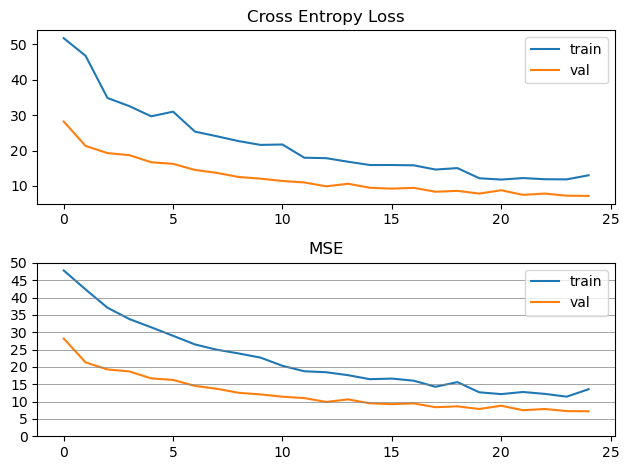

In [22]:
# visualize training history

plotTrainingHistory(train_history, val_history)

### Model testing

In [23]:
# load best model

model = resnet50(pretrained=False) 
model.fc = nn.Linear(2048, 1)

model.load_state_dict(torch.load("lego_counter_best_model.pth")['model'])



c:\Users\Henrique\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


<All keys matched successfully>

In [24]:
# evaluate model on test data

test_loss, test_acc = epoch_iter(test_dataloader, model, loss_fn, is_train=False)
print(f"Test loss: {test_loss:.3f}, Test accuracy: {test_acc:.3f}")

100%|██████████| 1/1 [00:03<00:00,  3.52s/it]

Test loss: 12.014, Test accuracy: 12.014


In [25]:
import matplotlib.pyplot as plt

def show_predictions(model, dataloader, num_images=9):
    '''
    Display images along with their true and predicted labels
    '''
    model.eval()
    all_preds = []
    all_labels = []
    all_images = []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            preds = model(images)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_images.extend(images.cpu().numpy())
            if len(all_images) >= num_images:
                break

    fig, axs = plt.subplots(3, 3, figsize=(9, 9))
    for i, ax in enumerate(axs.flatten()):
        ax.imshow(all_images[i].transpose((1, 2, 0)))
        ax.set_title(f'True label: {all_labels[i]}, Predicted label: {int(all_preds[i].round())}')
        ax.axis('off')
    plt.tight_layout(pad=3.0)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


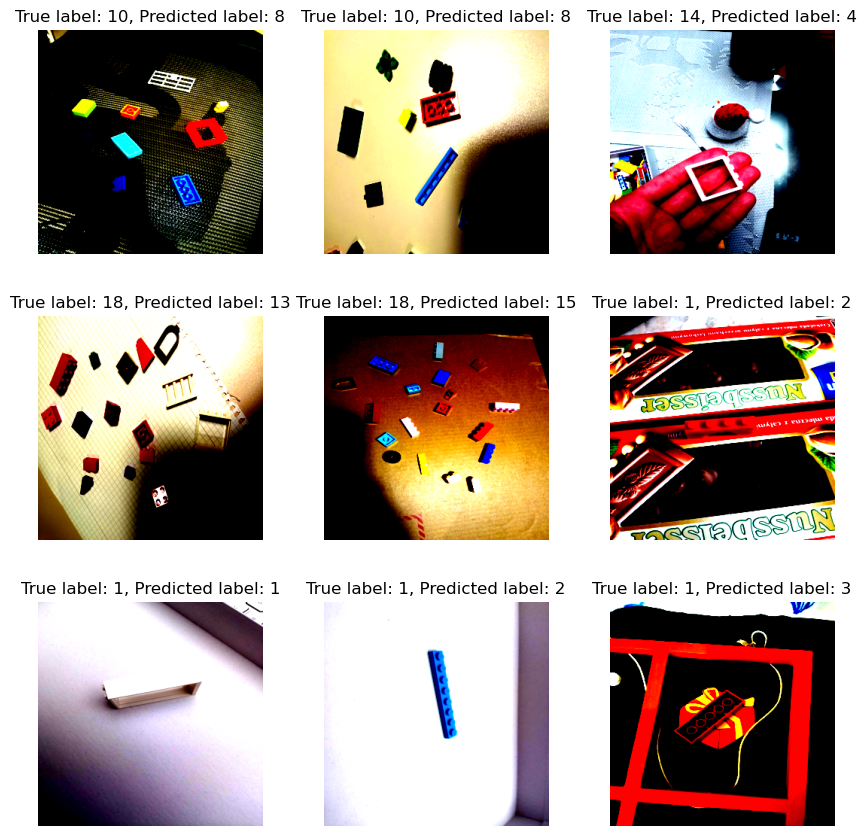

In [26]:
# view predictions

show_predictions(model, test_dataloader)